In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt, animation, rc
from datetime import datetime, timedelta

from IPython.display import Image
rc('animation', html='html5')
import cmocean 
from cartopy import crs, feature

sys.path.append('/Users/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

fatal: not a git repository (or any of the parent directories): .git


In [2]:
paths = path(1)
outfile = '/Users/jvalenti/MOAD/results/Iona_2019_repeat20190101_1n_20190116_1n.nc'
data = xr.open_dataset(outfile)
coords =  xr.open_dataset(paths['coords'], decode_times=False)
mask =  xr.open_dataset(paths['mask'])
time = data.time[0,:]

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/jvalenti/MOAD/grid/mesh_mask201703.nc'

In [ ]:
def order_data_bytime(data):  #Here we encapsulate everything that happens at the same time together (It is easier to animate this way) 
    '''Change to use your variables of interest'''
    DS = data.to_dataframe()
    lon = np.array(DS.sort_values(by='time').lon)
    lat = np.array(DS.sort_values(by='time').lat)
    z = np.array(DS.sort_values(by='time').z)
    age = np.array(DS.sort_values(by='time').tau)/3600
    T = np.array(DS.sort_values(by='time').time)

    Tint = []
    for ti in T:
        try:
            Tint.append(int(ti)) 
        except TypeError: 
            pass
            
    Tint = np.array(Tint)
    Age = []
    Z = []
    Lat = []
    Lon = []
    t = time[0]
    while int(t) < int(time[-1]): 
        Lat.append(lat[np.where(Tint==int(t))])
        Lon.append(lon[np.where(Tint==int(t))])
        Age.append(age[np.where(Tint==int(t))])
        Z.append(z[np.where(Tint==int(t))])
        t+=np.timedelta64(2, 'h')

    return Lat,Lon,Age,Z

In [4]:
Lat,Lon,Age,Z = order_data_bytime(data)
Dat=xr.open_dataset(paths['coords'],decode_times=False)
#This is specific for Iona Outfall
outf_lat=Dat['nav_lat'][445,304] 
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)] #My deploy location, only important if you want to mark the location.

In [5]:
def scatter_particles(ax,nmin,lat,lon,Z,vmin,vmax,Map=1): 
    scatter=[]
    if Map == 0:     
        scatter.append(ax.scatter(lon[nmin], lat[nmin],s=4,c=Z[nmin],cmap=cmocean.cm.tempo,vmin=vmin,vmax=vmax,alpha=0.5))  
    else:
        scatter.append(ax.scatter(lon[nmin], lat[nmin],s=4,c=Z[nmin],cmap=cmocean.cm.tempo,vmin=vmin,vmax=vmax,alpha=0.5,
                                  zorder=3,transform=crs.PlateCarree()))
    return scatter

def mapanimation(outfile,clon,clat,vmin,vmax,fps=1,Map=1):
    
    ds = xr.open_dataset(outfile) #This function just loads data
    time = ds.time[0,:]
    Lat,Lon,Age,Z = order_data_bytime(ds)
    
    fig = plt.figure(figsize=(8, 8))
    lonmin = np.min(ds.lon)
    lonmax = np.max(ds.lon)
    latmin = np.min(ds.lat)
    latmax = np.max(ds.lat)
    ax = plt.axes(xlim=(lonmin,lonmax),ylim=(latmin,latmax))
    plt.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray',zorder=1)
    plt.scatter(clon,clat,color='r',zorder=5)
    ax.grid()
    f = 1.0/np.cos(49.5*np.pi/180)
    plt.gca().set_aspect(f)

    def update(frame):
        global ss
        for scat in ss:
            scat.remove()
        t = ax.text(0.02, 0.02, '', color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'), transform=ax.transAxes)
        tstamp = time[frame].values.astype('datetime64[s]').astype(datetime)
        t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))
        ss = scatter_particles(ax, frame, Lat,Lon,Age,vmin,vmax,Map)
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(time[:-1]),fps))


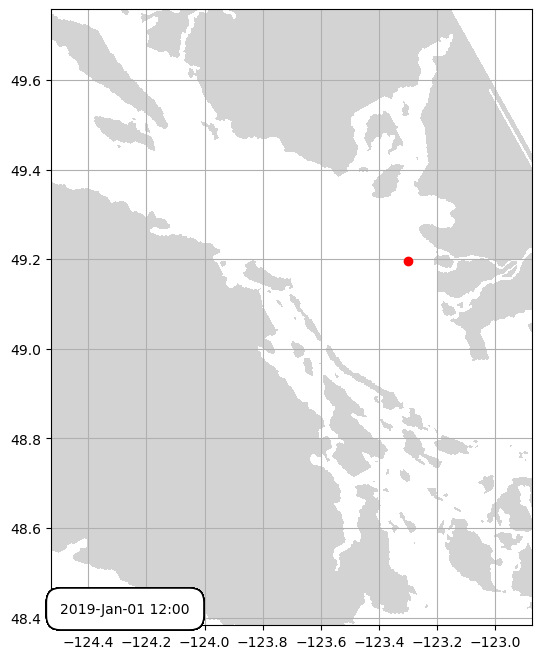

In [6]:
anim = mapanimation(outfile,clon,clat,0,350,10,Map=0)

f2 = r"/Users/jvalenti/anim.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f2, writer = FFwriter)

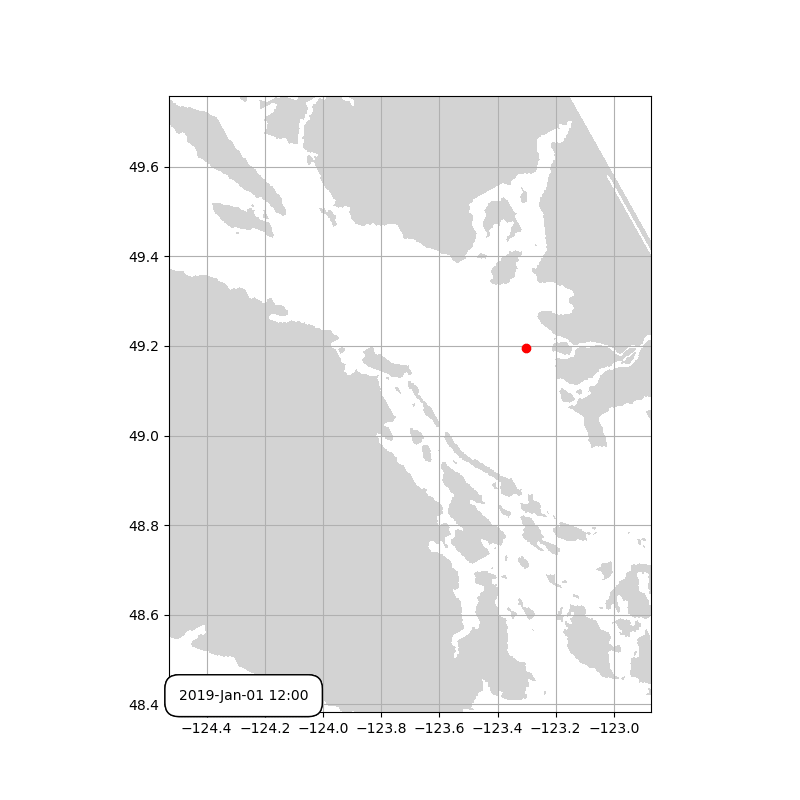

In [7]:
with open(f2,'rb') as anim:
     display(Image(anim.read()))

In [8]:
#Same animation using Cartopy
ds=data
time = ds.time[0,:]
Lat,Lon,Age,Z = order_data_bytime(ds)

fig = plt.figure(figsize=(8, 8))
lonmin = np.min(ds.lon) -0.5
lonmax = np.max(ds.lon) +0.5
latmin = np.min(ds.lat) -0.5
latmax = np.max(ds.lat) +0.5

<Figure size 800x800 with 0 Axes>

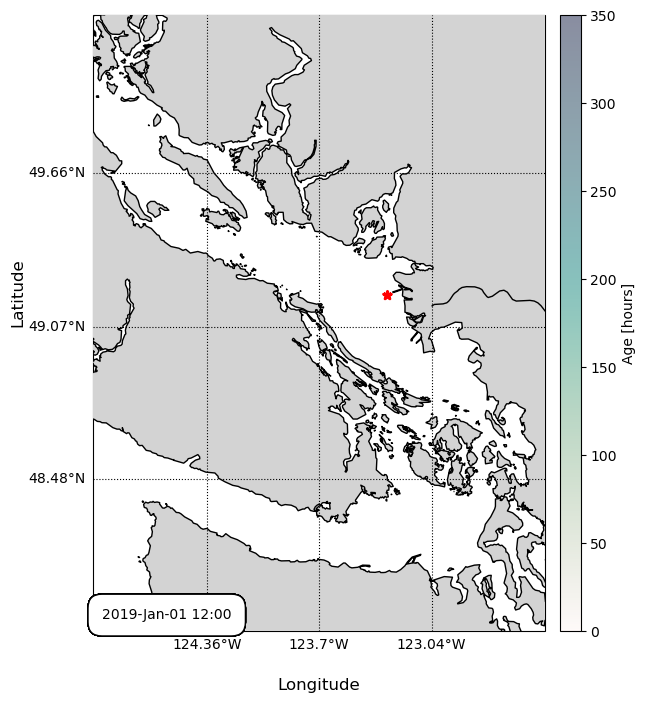

In [9]:
fps = 15 #Not really fps, this will determine which frames you are using. For 15 you are using 1 time every 15 in your data.
# Make map
fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('high', edgecolor='k', facecolor='lightgray'),zorder=4)
ax.add_feature(feature.RIVERS, edgecolor='k',zorder=5)
a = ax.scatter(Lon[0], Lat[0],s=4,c=Age[0],cmap=cmocean.cm.tempo,vmin=0,vmax=350,alpha=0.5,zorder=3,transform=crs.PlateCarree())
cbar = fig.colorbar(a, location='right',aspect=30,shrink=1,pad=0.01)
cbar.set_label('Age [hours]')
gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=np.round(np.linspace(lonmin,lonmax,5),2), ylocs=np.round(np.linspace(latmin,latmax,5),2),zorder=5)
gl.top_labels, gl.right_labels = False, False

ax.scatter(clon,clat,c='r', marker='*', linewidth=2,transform=crs.PlateCarree(),zorder=4)    
ax.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ss = []
def animate(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax,frames, Lat,Lon,Age,0,350)
    t = ax.text(0.02, 0.02, '', color='black', 
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'), transform=ax.transAxes,zorder=5)
    tstamp = time[frames].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))

anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(time[:-1]),fps))

f = r"/Users/jvalenti/MOAD/animations/storm2.gif" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)

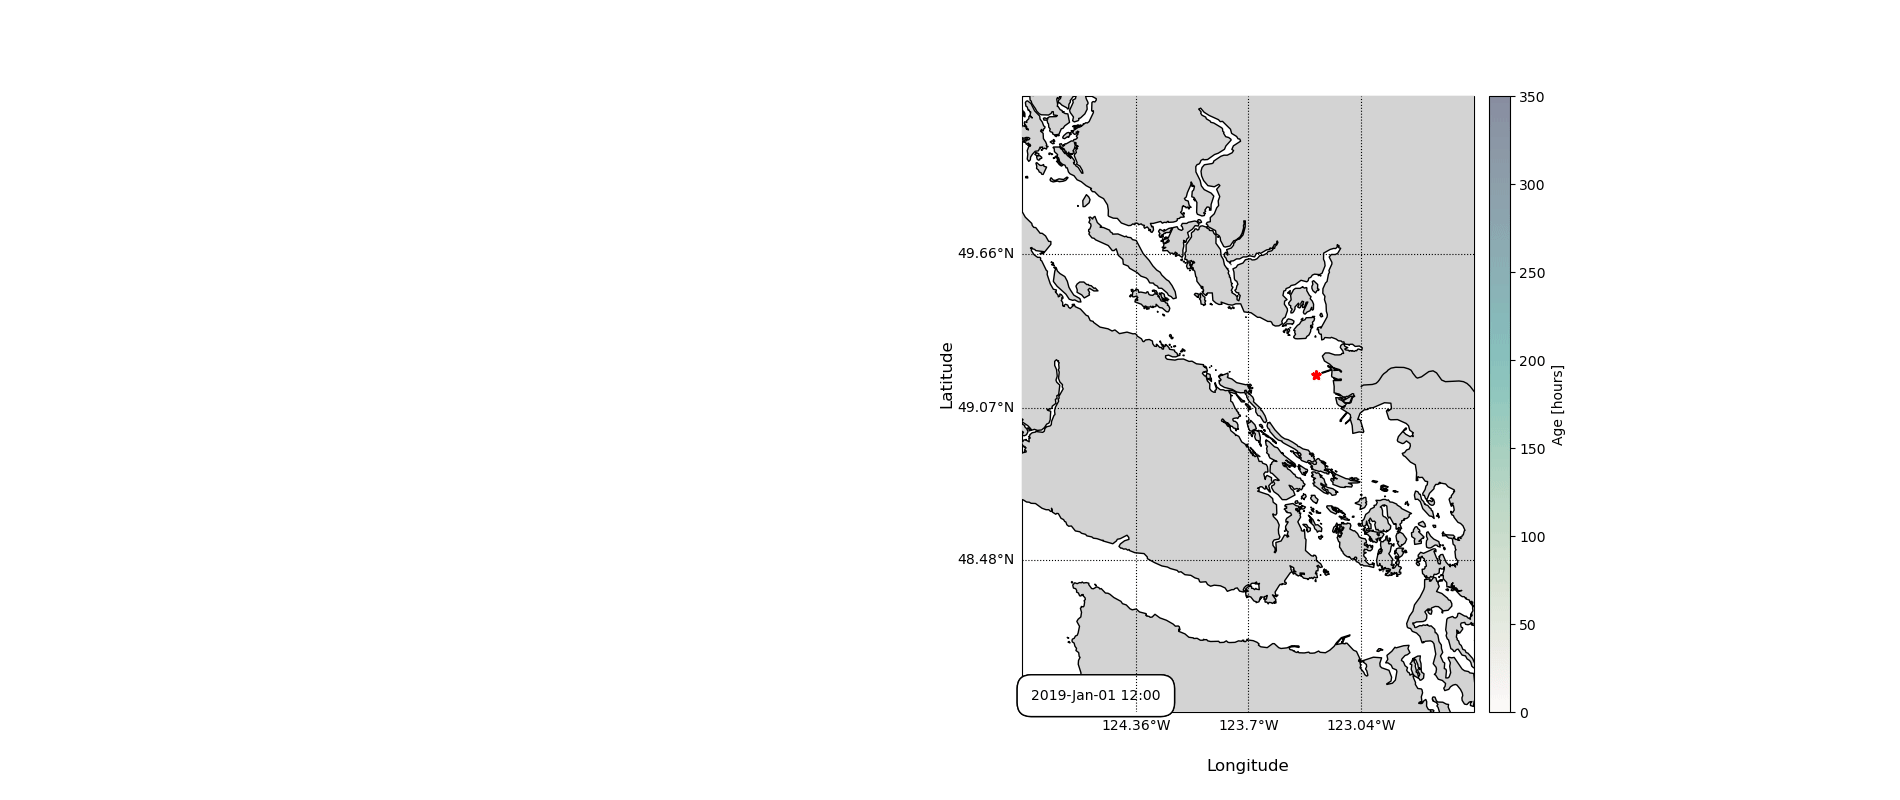

In [10]:
with open(f,'rb') as anim:
     display(Image(anim.read()))